<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/DolBaKi/%EB%94%A5%EB%9F%AC%EB%8B%9D/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet
### 용어보기
1. ResNet : 스킵 구조를 이용한 CNN
2. 기울기 소실 : 은닉층 깊어지면서 입력층 가까운 가중치들 기울기가 0에 가까워지는 현상=>Sigmoid
3. 배치 정규화 : 각 배치 분포를 동일하게 만들어줌
4. nn.Wequential : 커스터마이징 불가 but forward메서드 작성필요 없어짐
5. 스킵 커넥션 : 은닉층 안거친 입력값과 은닉층 결과를 더하는 구조 (별 5개)
6. 평균 풀링 : 커널의 평균값 이용하는 풀링

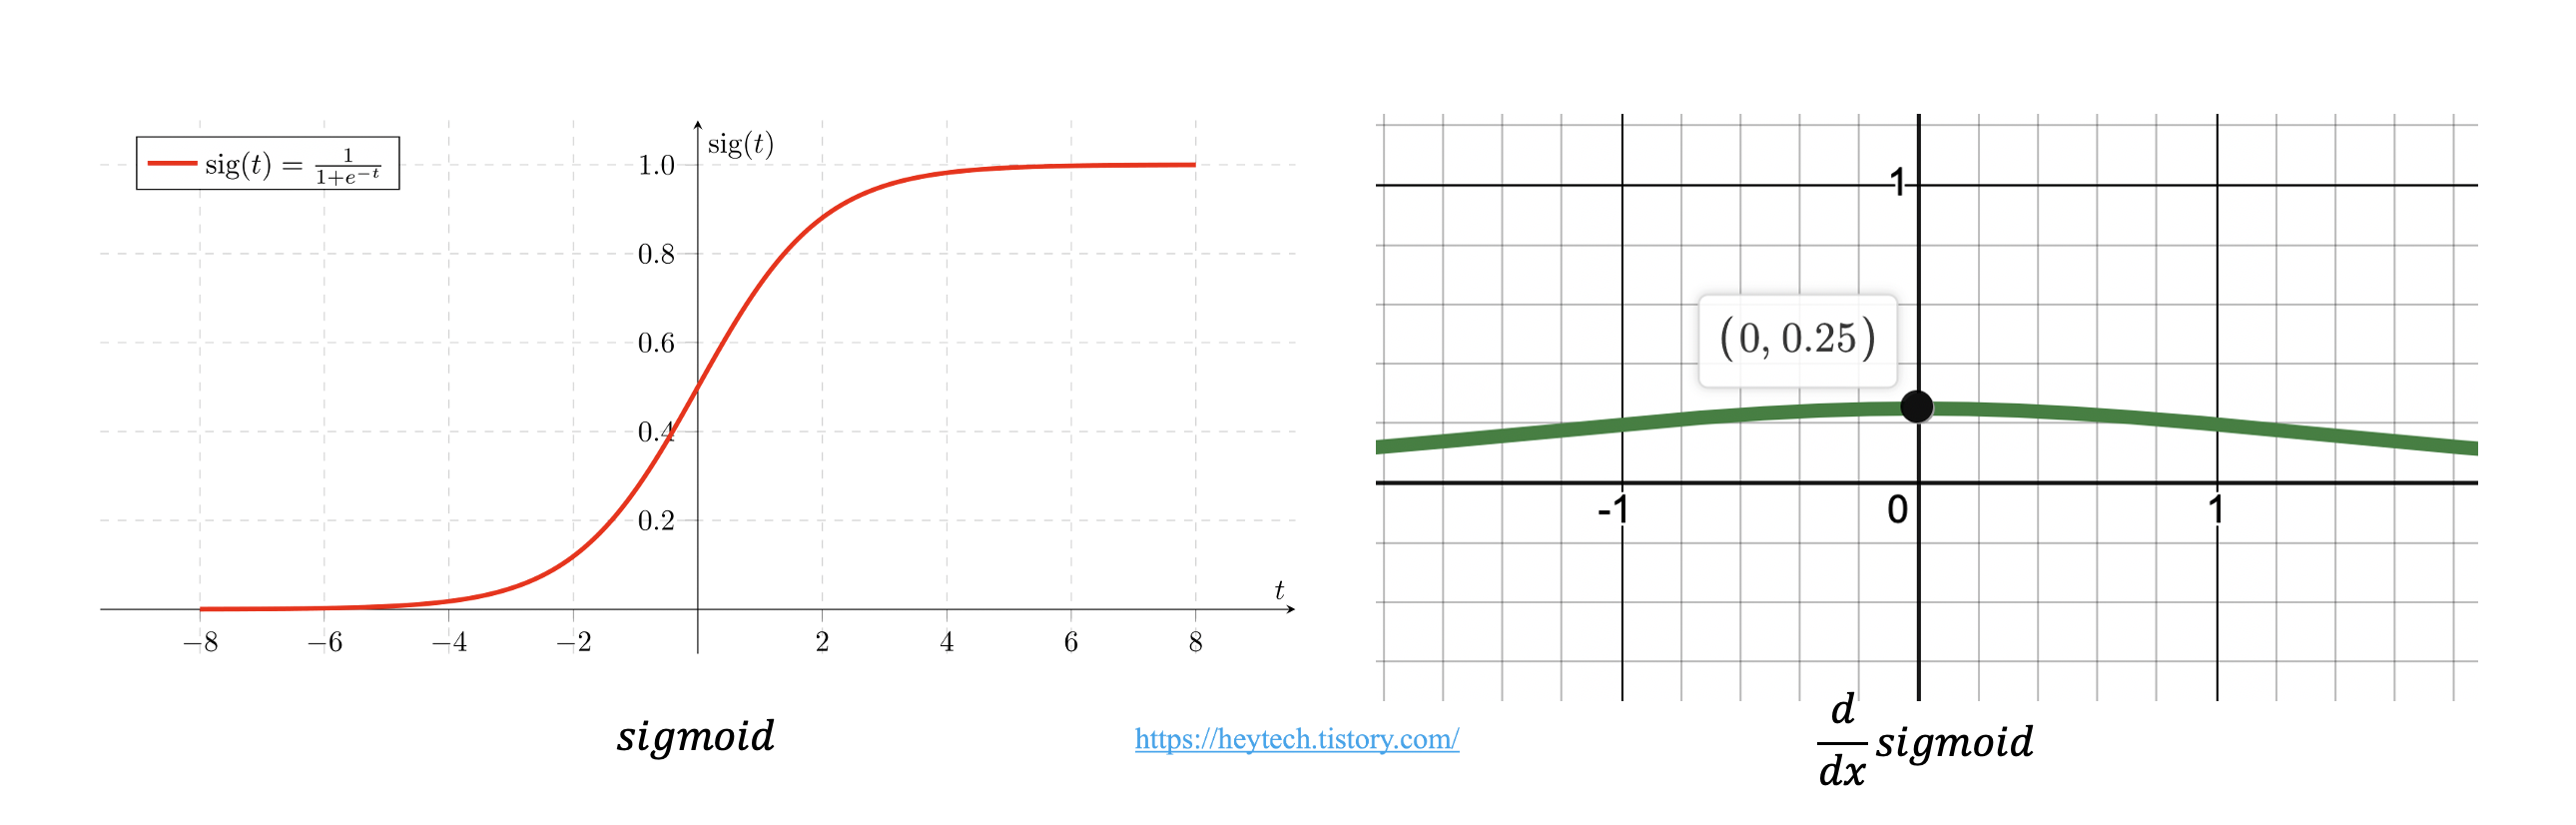

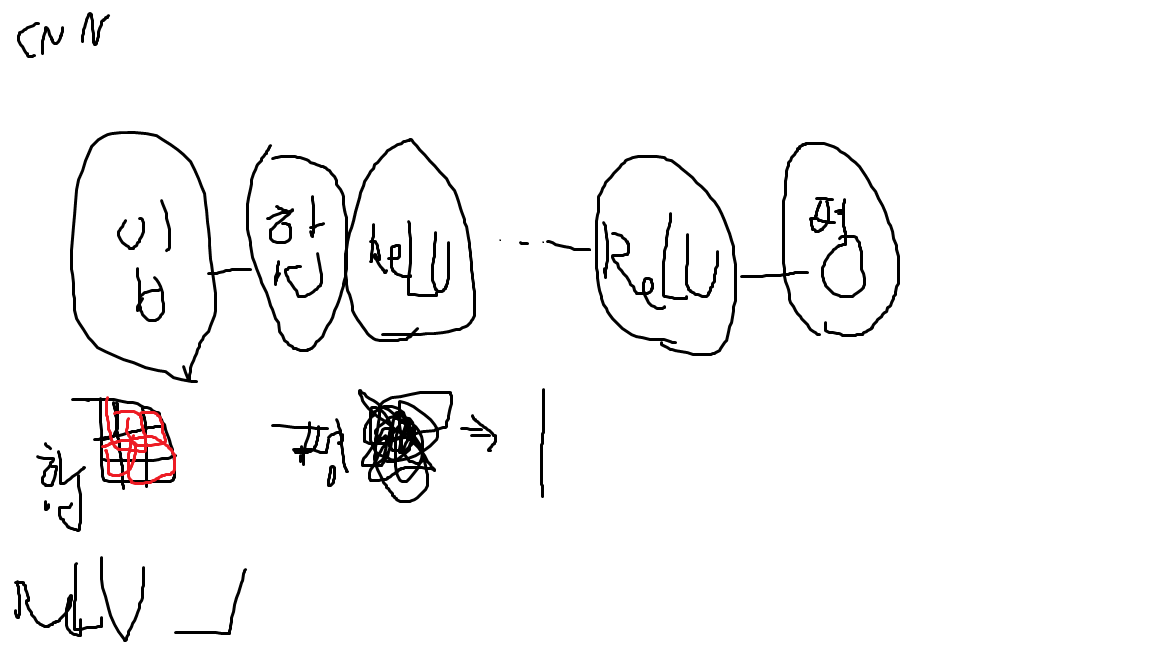

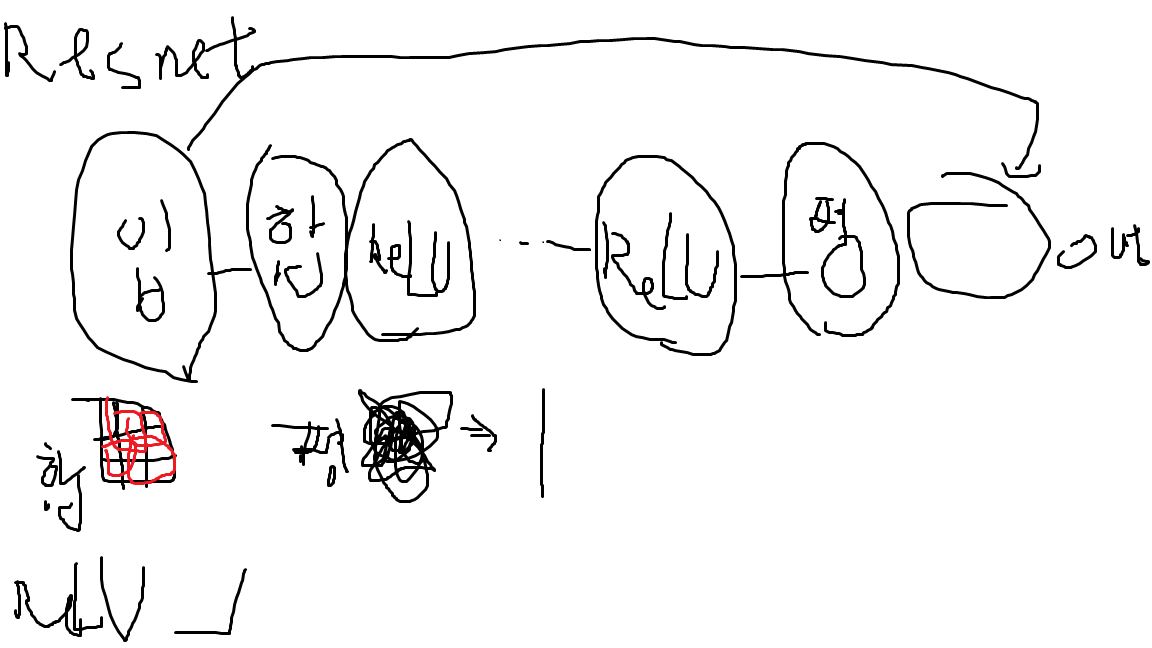

In [1]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size=3):
       super(BasicBlock, self).__init__()


        # 합성곱 정의
       self.c1 = nn.Conv2d(in_channels, out_channels,
                           kernel_size=kernel_size, padding=1)
       self.c2 = nn.Conv2d(out_channels, out_channels,
                           kernel_size=kernel_size, padding=1)
        # 다운샘플 : 채널 개수가 in_channels 에서 out_channels개로 바뀜.
       self.downsample = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1)

        # 배치 정규화층 정의
       self.bn1 = nn.BatchNorm2d(num_features=out_channels) # 배치 정규화 코드
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()

   def forward(self, x):
        # 스킵 커넥션을 위해 초기 입력을 저장
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

        # 합성곱의 결과와 입력의 채널 수를 맞춤
       x_ = self.downsample(x_)

        # 합성곱층의 결과와 저장해놨던 입력값을 더해줌
       x += x_ # 마지막에 합해주는것(ResNet)
       x = self.relu(x)

       return x

In [2]:
class ResNet(nn.Module):
   def __init__(self, num_classes=10):
       super(ResNet, self).__init__()


        # 블록
       self.b1 = BasicBlock(in_channels=3, out_channels=64)
       self.b2 = BasicBlock(in_channels=64, out_channels=128)
       self.b3 = BasicBlock(in_channels=128, out_channels=256)


        # 풀링을 max아닌 mean
       self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # 평균풀링 활성화 코드

        # 분류기
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=512)
       self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.b1(x)
       x = self.pool(x)
       x = self.b2(x)
       x = self.pool(x)
       x = self.b3(x)
       x = self.pool(x)


        # 분류기의 입력으로 사용하기 위해 flatten
       x = torch.flatten(x, start_dim=1)

        # 분류기로 예측값 출력
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x


In [3]:
import tqdm
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
   RandomCrop((32, 32), padding=4), #랜덤 크롭핑
   RandomHorizontalFlip(p=0.5), #랜덤 y축 대칭
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])


In [4]:
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12991546.24it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(num_classes=10)
model.to(device)

ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [7]:
lr = 1e-4 # 상수
optim = Adam(model.parameters(), lr=lr) # 아담쓰기

for epoch in range(10):
   iterator = tqdm.tqdm(train_loader)
   for data, label in iterator:
        # 옵티마이저 기울기 초기화
       optim.zero_grad()
        # 모델 accuracy
       preds = model(data.to(device))
        # loss 계산 후 역전파
       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()
       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), "ResNet.pth")

epoch:10 loss:0.1270921528339386: 100%|██████████| 1563/1563 [00:48<00:00, 32.46it/s]


In [8]:
model.load_state_dict(torch.load("ResNet.pth", map_location=device))
num_corr = 0
with torch.no_grad():
   for data, label in test_loader:
       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr
   print(f"Accuracy:{num_corr/len(test_data)}")
 # accuracy최댓값 출력하기

Accuracy:0.8701
